# Deploy ControlNet Canny Technique for Stable Diffusion on a SageMaker GPU Single-Model Endpoint

This notebook walks you through the deployment of a ControlNet tecnique with Stable Diffusion ona SageMaker GPU endpoint.

[![Open In Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/aws-samples/ad-creatives-and-gen-ai-stable-diffusion/ControlNet.ipynb)

# Background
With [ControlNet](https://huggingface.co/lllyasviel/ControlNet) we can control the generated images from Stable Diffusion models. There are various techniques of ControlNet, however, in this notebook we will show how to deploy the [Canny](https://huggingface.co/lllyasviel/sd-controlnet-canny) technique to a SageMaker endpoint

SetUp environment for SageMaker Studio Lab with AWS Credentials

In [ ]:
%pip install awscli

In [12]:
!mkdir ~/.aws

In [18]:
%%writefile ~/.aws/credentials

[default]
aws_access_key_id =  <ACCESS ID>   # IAM user Access key
aws_secret_access_key = <SECRET KEY>  # IAM user Secret key

Overwriting /home/studio-lab-user/.aws/credentials


In [19]:
%%writefile ~/.aws/config

[default]
region=us-east-1  # region

Overwriting /home/studio-lab-user/.aws/config


Installing and importing required modules

In [1]:
import os
!pip install sagemaker
!pip install huggingface_hub
!pip install PIL
!pip install matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import sagemaker
import shutil
from distutils.dir_util import copy_tree
from pathlib import Path
import boto3
import sagemaker
from huggingface_hub import snapshot_download
from sagemaker.huggingface import HuggingFaceModel
import tarfile
import os
import json 
import base64
import io
from PIL import Image
bucket_name='BUCKET NAME'
sess = sagemaker.Session(boto3.session.Session(),default_bucket=bucket_name)
role = "SAGEMAKER ROLE ARN"
bucket=sess.default_bucket()

Creating directories to hold models and inference scripts

In [2]:
technique='canny'
os.makedirs(f'script/{technique}/',exist_ok=True)
os.makedirs(f'compressed/{technique}/',exist_ok=True)

The SageMaker inference toolkit is built on the multi-model server (MMS). MMS expects a [Python script](https://docs.aws.amazon.com/sagemaker/latest/dg/adapt-inference-container.html) that implements functions to load the model, pre-process input data, get predictions from the model, and process the output data in a model handler.
Here we write logic to load model under the `model_fn(model_dir)` function and logic to process the inference request under the `transform_fn(model, data, input_content_type,output_content_type )` function


In [3]:
%%writefile script/canny/inference.py

import cv2
import numpy as np
from PIL import Image
import torch
import json
import os
import io
import base64
from io import BytesIO
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, DPMSolverMultistepScheduler, UniPCMultistepScheduler
import boto3
from pathlib import Path


def _encode(image):
    img = image
    img_byte_arr = io.BytesIO()
    img.save(img_byte_arr, format='PNG')
    img_byte_arr = img_byte_arr.getvalue()
    img_byte_arr=base64.b64encode(img_byte_arr).decode()
    return img_byte_arr

def _decode(image):
    image=base64.b64decode(image)
    image=Image.open(io.BytesIO(image))
    return image


# inference functions ---------------
def model_fn(model_dir):  
    
    control_net_postfix=[
            "canny",
            "depth",
            "hed",
            "mlsd",
            "openpose",
            "scribble"
        ]
    
    control_net=[x for x in os.listdir() if x in control_net_postfix][0]
   
    # Creating pipeline model
    controlnet = ControlNetModel.from_pretrained(
        f"{model_dir}/{control_net}",
        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
    )
    pipe = StableDiffusionControlNetPipeline.from_pretrained(
        f"{model_dir}/v1-5",
        controlnet=controlnet,
        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
    )
    # change the scheduler
    pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
    if torch.cuda.is_available():
        # enable xformers (optional), requires xformers installation
        pipe.enable_xformers_memory_efficient_attention()
        # cpu offload for memory saving, requires accelerate>=0.17.0
        pipe.enable_model_cpu_offload()
    return pipe

def transform_fn(model, data, input_content_type,output_content_type ):
   
    input_data=json.loads(data)   
    
    # Canny Function
    image=_decode(input_data['image']) 
    image = np.array(image)
    low_threshold = int(input_data["low_threshold"])  if "low_threshold" in input_data.keys() else 100
    high_threshold = int(input_data["high_threshold"]) if "high_threshold" in input_data.keys() else 200
    image = cv2.Canny(image, low_threshold, high_threshold)
    image = image[:, :, None]
    image = np.concatenate([image, image, image], axis=2)
    canny_image = Image.fromarray(image)
    
    seed=int(input_data["seed"])  if "seed" in input_data.keys() else 12345
    print(seed) 
    if torch.cuda.is_available():
        generator = torch.Generator('cuda').manual_seed(seed)       
    else:
        generator = torch.Generator().manual_seed(seed)

    # Generating output image
    output_image = model(
    input_data["prompt"],
    negative_prompt=input_data["negative_prompt"],
    num_inference_steps=int(input_data["steps"])  if "steps" in input_data.keys() else 20,
    generator=generator,
    image=canny_image,
    controlnet_conditioning_scale=float(input_data["scale"])  if "scale" in input_data.keys() else 0.5,
    ).images[0]    
    output = _encode(output_image) 
    output_canny=_encode(canny_image)
    # Returning the output image and canny edge image
    response={"output_image":output,
         "canny_image":output_canny        
        }
    return response
    

Writing script/canny/inference.py


Writing a `requirements.txt` file with all the dependencies needed. This would be installed by the SageMaker inference container. This would be in the same directory that holds the inference script. [SageMaker Inference Directory Structure](https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html#:~:text=If%20there%20are%20other%20packages,put%20in%20the%20same%20folder.)

In [4]:
%%writefile script/canny/requirements.txt

diffusers
accelerate
opencv-contrib-python
controlnet-aux
xformers
opencv-python-headless
transformers

Writing script/canny/requirements.txt


In [ ]:
%%time
model_id = ["runwayml/stable-diffusion-v1-5","lllyasviel/sd-controlnet-canny"]
# Creating a tarfile to to compress our model to a `tar.gz` format as required by SageMaker
tar = tarfile.open(f"compressed/{technique}/{technique}.tar.gz", "w:gz",compresslevel=2)
for ids in model_id:
    # Create local dir to download models into
    model_tar_dir = Path(ids.split("/")[-1])
    if model_tar_dir.exists():
        shutil.rmtree(str(model_tar_dir))
    model_tar_dir.mkdir(exist_ok=True)
    name=ids.split('-',2)[-1]
    
    # unwanted checkpoint files in sdv1.5 to reduce weight of model
    unwanted_files_sd=["v1-5-pruned-emaonly.safetensors","*ckpt","v1-5-pruned.safetensors","v1-inference.yaml"]
    
    # Download model from Hugging Face into model_dir and adding to the tarfile then deleting from local directory
    if ids =="runwayml/stable-diffusion-v1-5":
        snapshot_download(ids, local_dir=str(model_tar_dir), local_dir_use_symlinks=False,ignore_patterns=unwanted_files_sd)
        tar.add(str(model_tar_dir),arcname=f"{name}")
        !rm -r {str(model_tar_dir)}        
    else:
        snapshot_download(ids, local_dir=str(model_tar_dir), local_dir_use_symlinks=False) 
        tar.add(str(model_tar_dir),arcname=name)
        !rm -r {str(model_tar_dir)}
# Adding the inference scripts and requirements file to the tarfile
tar.add(f"script/{technique}/",arcname='code')
tar.close()    

Fetching 21 files:   0%|          | 0/21 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

CPU times: user 10min 42s, sys: 36.6 s, total: 11min 18s
Wall time: 11min 8s


Copy the compressed model artiact to S3

In [ ]:
model_s3_uri=f"s3://{bucket}/model_controlnet/{technique}.tar.gz"
!aws s3 cp compressed/{technique}/{technique}.tar.gz {model_s3_uri}

Configuring the Endpoint.
Here we use the HuggingFace Pytorch framework container for inference  

In [ ]:
from sagemaker.huggingface.model import HuggingFaceModel
image_uri ="763104351884.dkr.ecr.us-east-1.amazonaws.com/huggingface-pytorch-inference:1.13.1-transformers4.26.0-gpu-py39-cu117-ubuntu20.04"
huggingface_model = HuggingFaceModel(
   model_data=model_s3_uri,  # path to your trained sagemaker model
   role=role, # iam role with permissions to create an Endpoint  
   py_version="py39", # python version of the DLC  
   image_uri=image_uri, # sagemaker container image uri 
   env={
        "MMS_MAX_RESPONSE_SIZE": "20000000",
        "SAGEMAKER_CONTAINER_LOG_LEVEL": "20",
        "SAGEMAKER_PROGRAM": "inference.py",
        "SAGEMAKER_REGION": "us-east-1",
        "SAGEMAKER_SUBMIT_DIRECTORY": "/opt/ml/model/code"
        }
)

Deploy model to an endpoint

In [ ]:
# Deploying the model
from sagemaker.deserializers import JSONDeserializer,NumpyDeserializer
from sagemaker.serializers import CSVSerializer, JSONSerializer, IdentitySerializer

predictor = huggingface_model.deploy(
   initial_instance_count=1,
   instance_type= "ml.g5.xlarge"  
)

-------------!

Reading input file and creating prompt

In [9]:
with open(r"sportscar.jpeg", "rb") as img:
    image = base64.b64encode(img.read())  

p_p="metal orange colored car, complete car, colour photo, outdoors in a pleasant landscape, realistic, high quality"
n_p="cropped, out of frame, worst quality, low quality, jpeg artifacts, ugly, blurry,bad proportions"

request={"prompt":p_p,
         "negative_prompt":n_p,
         "image":image.decode(),
         "scale": 0.5,
         "steps":20,
         "low_threshold":100,
         "high_threshold":200,
         "seed": 123
        }

Running inference by passing the payload to the endpoint

In [10]:
%%time
import json
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import BytesDeserializer
predictor.serializer=JSONSerializer()#change serializer depending on request data format
predictor.deserializer=BytesDeserializer()
response=predictor.predict(request)


CPU times: user 28.5 ms, sys: 555 µs, total: 29.1 ms
Wall time: 7.15 s


In [23]:
def _decode(image):
    image=base64.b64decode(image)
    image=Image.open(io.BytesIO(image))
    return image

output=json.loads(response.decode())

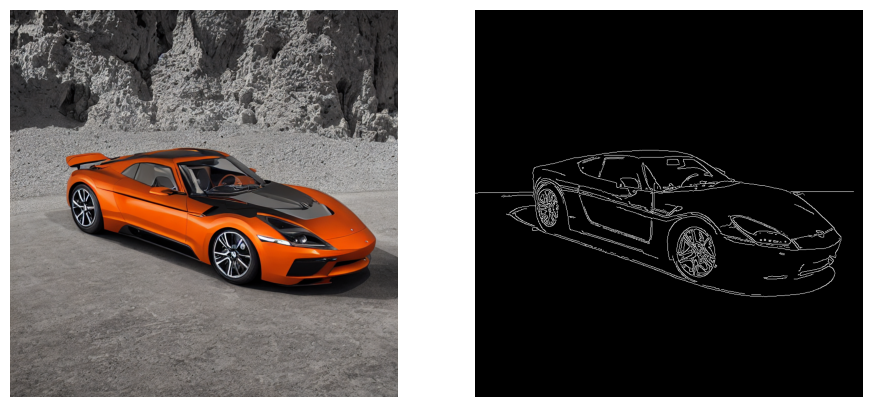

In [24]:
%matplotlib inline
rcParams['figure.figsize'] = 11 ,8
image = _decode(output["output_image"])
image_canny=_decode(output["canny_image"])
fig, ax = plt.subplots(1,2)
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[0].imshow(image)
ax[1].imshow(image_canny)